# ELG7113 Machine Learning for Adaptive and Intelligent Control Systems

Student: Derek Boase

Std Num: 300043860

e-mail: dboas065@uottawa.ca

assignment GitHub: git@github.com:derekboase/Adaptive_Control_Code.git

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from sympy.abc import p, omega, theta, zeta
from scipy.integrate import odeint
from numpy import cos, sin, pi

## Question 1: MIT Rule

In [2]:
y, ym, ydot, yddot, u, uc = sp.symbols('y,y_m,\dot{y},\ddot{y},u,u_c')
theta_1, theta_2 = sp.symbols('theta_1,theta_2')
a,b,am,bm = sp.symbols('a,b,a_m,b_m')

model = sp.Eq(yddot, -a*ydot + b*u)
u_eq = theta_1*(y - uc) - theta_2*ydot
model_u_sub = sp.Eq(sp.solve(sp.expand(model.subs(u, u_eq)), b*theta_1*uc)[0], b*theta_1*uc)
model_p = sp.Eq((-p**2 - p*(a+b*theta_2) + b*theta_1)*y, b*theta_1*uc) 


Gm = omega**2/(p**2 + 2*zeta*omega*p + omega**2)
ym_eq = sp.Eq(ym, Gm*uc)

### Q1.1: Derivation of MIT Rule Adaptation Laws

The model of the system is given by, 

{{model}}

where {{y}} is the output and {{u}} is the input. The adjustment law of the controller has two parameters, {{theta_1}} and {{theta_2}}, such that the input to the system is given as, 

{{sp.Eq(u, u_eq)}}

Substituting the input equation into the model equation gives,

{{model_u_sub}}

To solve for $y(t)$ the differential operator is used such that $p = \frac{d}{dt}$. With this substitution, the model is then given as, 

{{model_p}}

In [3]:
model_p = sp.Eq(y, sp.collect(sp.solve(model_p, y)[0], p))


This gives, 

{{model_p}}

To find the values of {{theta_1}} and {{theta_2}} for perfect model following, we consider the given model, 

{{ym_eq}}

By comparing the numerators of the model and the reference model, we find {{theta_1}} to be, 

In [4]:
num, denum = sp.fraction(model_p.rhs)
num_m, denum_m = sp.fraction(ym_eq.rhs)
theta_1_MF = sp.Eq(theta_1, sp.solve(num - num_m, theta_1)[0])
theta_2_MF = sp.Eq(theta_2, sp.solve((denum - denum_m).subs(theta_1, theta_1_MF.rhs), theta_2)[0])

Then for perfect model following the values of the parameters should be, 

{{theta_1_MF}} 

and

{{theta_2_MF}}

Next we find the sensitivity of the error function, $\frac{\partial e(\theta_1, \theta_2)}{\partial \theta_i}$, for $i \in\{1,2\}$. One note to make is that since $y_m$ doesn't depend on the parameters the sensitivities are given by the derivation of the output, $\frac{\partial y(\theta_1, \theta_2)}{\partial \theta_i}$

In [5]:
sens_1, sens_2 = sp.symbols('de/dt_1, de/dt_2')
sensitivity_1 = sp.diff(model_p.rhs, theta_1)
sensitivity_1 = sp.Eq(sens_1, sp.simplify(sensitivity_1))
sensitivity_2 = sp.diff(model_p.rhs, theta_2)
sensitivity_2 = sp.Eq(sens_2, sp.simplify(sensitivity_2))

The evaluation of these derivatives yeilds, 

{{sensitivity_1}}

{{sensitivity_2}}

In [6]:
sensitivity_1 = sensitivity_1.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs)
sensitivity_2 = sensitivity_2.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs)

These are dependent on the estimated parameters and thus require substitution of the perfect model following parameters, 

{{sensitivity_1}}

{{sensitivity_2}}

In [7]:
uc_sub = sp.solve(ym_eq, uc)[0]
sensitivity_1 = sensitivity_1.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs).subs(uc, uc_sub)
sensitivity_2 = sensitivity_2.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs).subs(uc, uc_sub)

By rearranging the equation for the reference model to solve for $u_c$ we get, 

{{sp.Eq(uc, uc_sub)}}

Substituting this into the sensitvity equations, 

{{sensitivity_1}}

{{sensitivity_2}}

Then, 

$ \dot{\theta_i} = -\gamma' e\frac{\partial e}{\partial \theta_i}$

Then the adaptation law's are given as, 

$ \dot{\theta}_1 = \gamma'e${{-sensitivity_1.rhs}}

$ \dot{\theta}_2 = \gamma'e${{-sensitivity_2.rhs}}

By defining $\gamma = \gamma'b$ we get

$ \dot{\theta}_1 = \gamma e${{-sensitivity_1.rhs/b}}

$ \dot{\theta}_2 = \gamma e${{-sensitivity_2.rhs/b}}

### Q1.2: Implementation of MIT Rule Adaptation Laws

In [8]:
# def model_sol(init, t):  # init = [0: ym, 1: ym', 2: y, 3: y', 4: theta, 5: theta', 6: theta'']
#     a, b = 3, 1
#     K = 2.0*1.5*0.6
#     C = 1.5**2
#     gamma = 1
    
#     # This block of code defines the parameter uc at time t
#     rat = 2.0*pi*t/30.0
#     if sin(rat) >= 0:
#         uc = 1
#     else: 
#         uc = 0
        
        
#     # Initial conditions 
#     ym, ym_prime = init[0], init[1]
#     y, y_prime = init[2], init[3]
#     theta_1, theta_1_prime, theta_1_pprime = init[4], init[5], init[6]
#     theta_2 = 0
    
#     # This block calculates ym, ym' and ym''
#     dym_dt = ym_prime
#     dym_prime_dt = -K*dym_dt - C*ym + C*uc
    
#     # This block calculates y, y' and y''
#     dy_dt = init[3]
#     dy_p_dt = (-a * -b*theta_2)*dy_dt + b*theta_1*(y - uc) 
    
#     # This block calculates theta_1, theta_1', theta_1'' and theta_1'''
#     dx1dt = theta_1_prime
#     dx2dt = theta_1_pprime
#     dx3dt = -K*dx2dt - dx1dt + gamma*(y - ym)*(K*dym_dt + dym_prime_dt) 
#     return [dym_dt, dym_prime_dt, dy_dt, dy_p_dt, theta_1, dx1dt, dx2dt, dx3dt]

# init = np.array([0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1])

# t = np.linspace(0, 100, 1001)
# sol = odeint(model_sol, init, t)

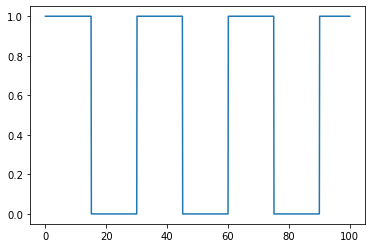

In [9]:
t = np.linspace(0, 100, 1001)
K = 2.0*1.5*0.6
C = 1.5**2 
def reference_signal(time=t):
    _uc = np.array([1])
    for _t in time[1:]:
        rat = 2.0*pi*_t/30.0
        _uc = np.concatenate((_uc, np.array([sin(rat)>= 0])), axis=0)
    return _uc
uc=reference_signal()
plt.plot(t, reference_signal())
plt.show()

In [12]:
ym_eq

Eq(y_m, omega**2*u_c/(omega**2 + 2*omega*p*zeta + p**2))

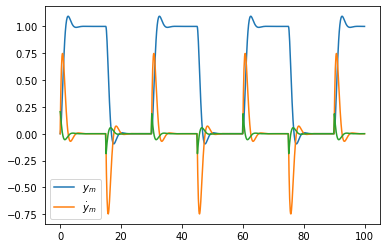

In [18]:
def model_response(init_m, t):  # init = [0: ym, 1: ym']       
    global C, K
    
    # Initial conditions 
    ym, ym_prime = init_m[0], init_m[1]
    
    uc = sin(2.0*pi*t/30.0) >= 0
    
    # This block calculates ym and ym'
    dym_dt = ym_prime
    d2ym_dt2 = -K*dym_dt - C*ym + C*uc
    
    return [dym_dt, d2ym_dt2]

init_m = np.array([0, 0])
model_sol = odeint(model_response, init_m, t)
ym, dym_dt = model_sol[:,0], model_sol[:,1]
d2ym_dt2 = np.gradient(model_sol[:,1])
plt.plot(t, ym)
plt.plot(t, dym_dt)
plt.plot(t, d2ym_dt2)
plt.legend(['$y_m$', '$\dot{y}_m$'])
plt.show()

0.0
1.1909314287794781e-05
1.1909314287794781e-05
2.3818628575589563e-05
2.3818628575589563e-05
0.002258973989062904
0.002258973989062904
0.004494129349550218
0.004494129349550218
0.0067292847100375325
0.0067292847100375325
0.014685142246363515
0.014685142246363515
0.01327992688129825
0.01327992688129825
0.01983056905255897
0.01983056905255897
0.02638121122381969
0.02638121122381969
0.03293185339508041
0.03293185339508041
0.04603313773760185
0.04603313773760185
0.05913442208012329
0.05913442208012329
0.07223570642264472
0.07223570642264472
0.08533699076516615
0.08533699076516615
0.09843827510768759
0.09843827510768759
0.14188162072490162
0.14188162072490162
0.13230603948983796
0.13230603948983796
0.16617380387198835
0.16617380387198835
0.20004156825413874
0.20004156825413874
0.1919694241603911
0.1919694241603911
0.2177650444487938
0.2177650444487938
0.2435606647371965
0.2435606647371965
0.2693562850255992
0.2693562850255992
0.2951519053140019
0.2951519053140019
0.32094752560240464
0.32

48.16391172597188
48.16391172597188
48.2867175567793
48.2867175567793
48.39607730752767
48.39607730752767
48.50543705827604
48.50543705827604
48.614796809024405
48.614796809024405
48.72415655977277
48.72415655977277
48.83351631052114
48.83351631052114
48.94287606126951
48.94287606126951
49.05223581201788
49.05223581201788
49.161595562766244
49.161595562766244
49.23458901269147
49.23458901269147
49.3075824626167
49.3075824626167
49.38057591254193
49.38057591254193
49.45356936246716
49.45356936246716
49.526562812392385
49.526562812392385
49.59955626231761
49.59955626231761
49.67254971224284
49.67254971224284
49.76807122780402
49.76807122780402
49.8635927433652
49.8635927433652
49.959114258926384
49.959114258926384
50.054635774487565
50.054635774487565
50.150157290048746
50.150157290048746
50.24567880560993
50.24567880560993
50.37476523703898
50.37476523703898
50.50385166846803
50.50385166846803
50.63293809989708
50.63293809989708
50.762024531326134
50.762024531326134
50.891110962755185
5

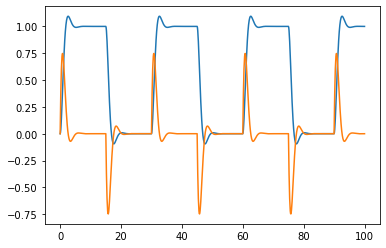

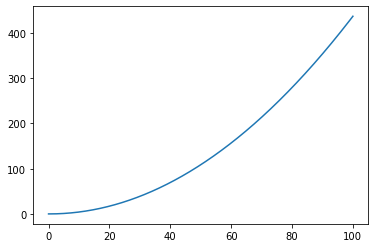

In [56]:
d2ym_dt2_arr = np.array([0])
def parameters(init, t):
    global C, K, d2ym_dt2_arr
    gamma = 1
    
    # Initial conditions
    ym, ym_prime = init[0], init[1]
    theta1, theta1_p, theta1_pp = init[2], init[3], init[4]
    
    uc = float(sin(2.0*pi*t/30.0) >= 0)
    
    # ym calculation
    dym_dt = ym_prime
    d2ym_dt2 = -K*dym_dt - C*ym + C*uc
    d2ym_dt2_arr = np.concatenate((d2ym_dt2_arr, 
                                   d2ym_dt2.reshape(-1,)), axis=0)  # This list is so I can differentiate it
    
    # y calculation
    
    e = 0.001 # dy_dt - dym_dt

    # Theta1 calculation
    M = gamma*e*(K*d2ym_dt2 + np.gradient(d2ym_dt2_arr)[-1])
    M = 0.8
    dth_dt = theta1_p
    d2th_dt2 = theta1_pp
    d3th_dt3 = -K*d2th_dt2 -C*d2th_dt2 + M/C
    
    return [dym_dt, d2ym_dt2, dth_dt, d2th_dt2, d3th_dt3]

init = np.array([0, 0, 0, 0, 0])
params_sol = odeint(parameters, init, t)
plt.plot(t, params_sol[:, 0])
plt.plot(t, params_sol[:, 1])
plt.show()

plt.plot(t, params_sol[:, 2])
plt.show()

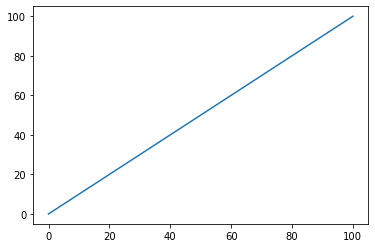

In [25]:
plt.plot(t, x)
plt.show()

## Question 2: Lyapunov Method